In [1]:
import numpy as np 
import pandas as pd 
import os 

print(os.listdir("Dataset/"))

['fundamentals.csv', 'prices-split-adjusted.csv', 'prices.csv', 'securities.csv']


In [2]:
# Import essential libraries for ARIMA Model and plotting

import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA


In [3]:
# importing data

df = pd.read_csv("Dataset/prices-split-adjusted.csv",index_col=0)

df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [7]:
df.symbol.unique()

array(['WLTW', 'A', 'AAL', 'AAP', 'AAPL', 'ABC', 'ABT', 'ACN', 'ADBE',
       'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES', 'AET',
       'AFL', 'AGN', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL',
       'ALXN', 'AMAT', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN',
       'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB',
       'AVGO', 'AVY', 'AWK', 'AXP', 'AYI', 'AZO', 'BA', 'BAC', 'BAX',
       'BBBY', 'BBT', 'BBY', 'BCR', 'BDX', 'BEN', 'BHI', 'BIIB', 'BK',
       'BLK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CA', 'CAG', 'CAH',
       'CAT', 'CB', 'CBG', 'CBS', 'CCI', 'CCL', 'CELG', 'CERN', 'CF',
       'CHD', 'CHK', 'CHRW', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA',
       'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COH',
       'COL', 'COO', 'COP', 'COST', 'CPB', 'CRM', 'CSCO', 'CSX', 'CTAS',
       'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE',
       'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISCA', 'DISCK', 

In [8]:
dfg = df[df['symbol']=='GOOG'] #Working on Google Stock

dfg.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,GOOG,312.304948,312.205308,310.955001,313.580158,3927000.0
2010-01-05,GOOG,312.419511,310.830459,309.610028,312.748278,6031900.0
2010-01-06,GOOG,311.761979,302.994813,302.048370,311.761979,7987100.0
2010-01-07,GOOG,303.562685,295.941242,295.218951,303.861575,12876600.0
2010-01-08,GOOG,294.895159,299.886470,293.455551,300.499172,9483900.0


In [9]:
dfg.index.sort_values()

Index(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
       '2010-01-11', '2010-01-12', '2010-01-13', '2010-01-14', '2010-01-15',
       ...
       '2016-12-16', '2016-12-19', '2016-12-20', '2016-12-21', '2016-12-22',
       '2016-12-23', '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30'],
      dtype='object', name='date', length=1762)

In [10]:
# converting index to pandas Datetime format

dfg.index = pd.to_datetime(dfg.index,format="%Y/%m/%d")

In [11]:
# now we consider only the closing price of the stock

df_final = dfg.drop(['symbol','open','low','high','volume'], axis=1)

# converting to a series(required for ARIMA)

df_final = pd.Series(df_final['close'])

In [12]:
type(df_final)

pandas.core.series.Series

## Checking Stationarity of Data 
- We do this because ARIMA would not work on non-stationary data and we need to use the method of differencing if possible to convert the data to stationary data for time series forecasting
- We use the **Dickey-Fuller** test for this purpose

In [15]:
def check_stationarity(ts_data):
    # checking rolling stats with 30 past points
    roll_mean = ts_data.rolling(30).mean()
    roll_std = ts_data.rolling(30).std()

    # plotting the stats

    fig = plt.figure(figsize=(20,10))
    plt.subplot(211)
    plt.plot(ts_data, color='black', label='Original Data')
    plt.plot(roll_mean, color='red', label='Rolling Mean(30 days)')
    plt.legend()
    plt.subplot(212)
    plt.plot(roll_std, color='green', label='Rolling Std Dev(5 days)')
    plt.legend()
    
    # Dickey-Fuller test
    print('Dickey-Fuller test results\n')
    df_test = adfuller(ts_data, regresults=False)
    test_result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','# of lags','# of obs'])
    print(test_result)
    for k,v in df_test[4].items():
        print('Critical value at %s: %1.5f' %(k,v))
    


Dickey-Fuller test results

Test Statistic      -0.166842
p-value              0.942360
# of lags            3.000000
# of obs          1758.000000
dtype: float64
Critical value at 1%: -3.43408
Critical value at 5%: -2.86319
Critical value at 10%: -2.56765


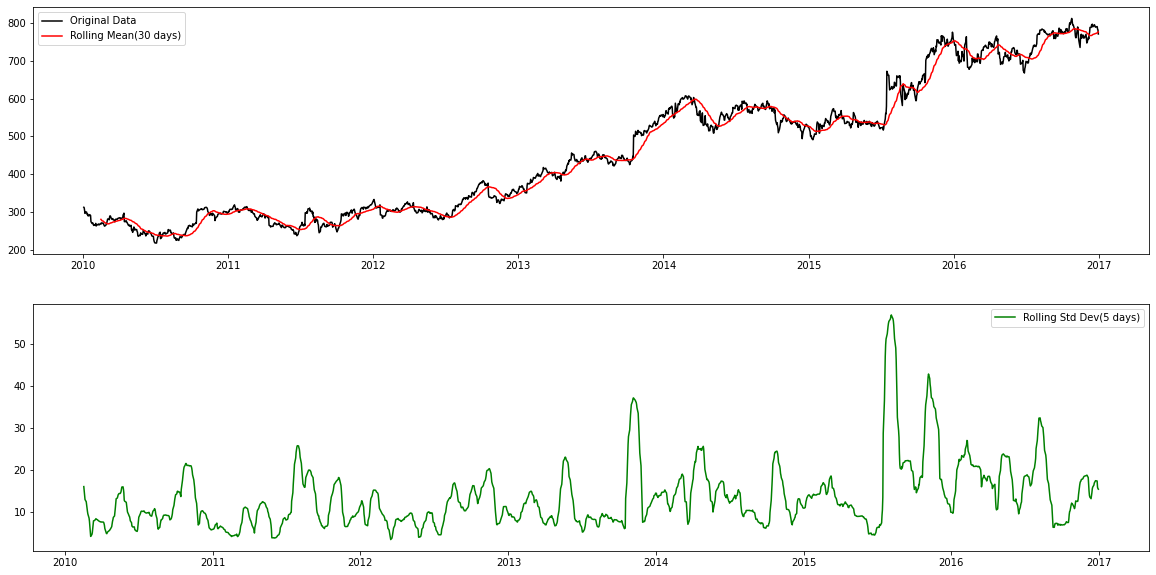

In [16]:
check_stationarity(df_final)

In [17]:
df_final_log = np.log(df_final)
df_final_log.head()

date
2010-01-04    5.743661
2010-01-05    5.739248
2010-01-06    5.713716
2010-01-07    5.690161
2010-01-08    5.703404
Name: close, dtype: float64

The above transformation suggests that using logarithmic transformation suits this dataset
